Stock investing Example, application of the reduction property

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

In [3]:
from robust_q_learning_v2 import *
from q_learning import *

Explanation of the example and definition of the parameters

In [4]:
mu   = [1/12, 1/12, 1/2, 1/6, 1/6]#[1/6, 1/6, 1/2, 1/12, 1/12]

mu_1 = [1/12, 1/6, 1/2, 1/6, 1/12]
mu_2 = [1/8, 1/8, 1/2, 1/8, 1/8]
mu_3 = [1/12, 1/4, 1/3, 1/4, 1/12]
mu_4 = [1/6, 1/6, 1/3, 1/6, 1/6]


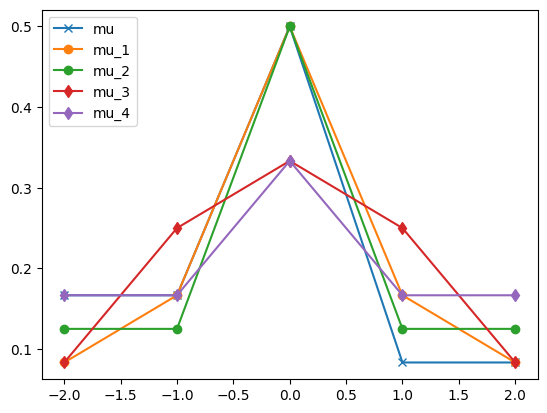

In [5]:
MU = np.array([mu, mu_1, mu_2, mu_3, mu_4]).T
X  = [-2, -1, 0, 1, 2]

plt.plot(X, mu, "-x", label = "mu")
plt.plot(X, mu_1, "-o", label="mu_1") 
plt.plot(X, mu_2, "-o", label="mu_2") 
plt.plot(X, mu_3, "-d", label="mu_3") 
plt.plot(X, mu_4, "-d", label="mu_4")
plt.legend(loc="upper left")
plt.show()

In [6]:
X = np.array([-2, -1, 0, 1, 2]) # States
A = np.array([0, 1]) # Actions

def r(x,a,y):
    return a * y

eps_greedy = 0.1   # Epsilon greedy policy
alpha      = 0.95  # Discount Factor
x_0        = 0     # Initial Value
k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2

In [7]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

In [8]:
def mu1(x,a,y):
    return mu_1[x_index(y)]
def mu2(x,a,y):
    return mu_2[x_index(y)]
def mu3(x,a,y):
    return mu_3[x_index(y)]
def mu4(x,a,y):
    return mu_4[x_index(y)]

def mu_tilde(x,a,y):
    return mu[x_index(y)]

In [9]:
def MU1(x,a):
    return X[np.random.choice(np.arange(len(mu_1)), p=mu_1)]
def MU2(x,a):
    return X[np.random.choice(np.arange(len(mu_2)), p=mu_2)]
def MU3(x,a):
    return X[np.random.choice(np.arange(len(mu_3)), p=mu_3)]
def MU4(x,a):
    return X[np.random.choice(np.arange(len(mu_4)), p=mu_4)]

def MU_tilde(x,a):
    return X[np.random.choice(np.arange(len(mu)), p=mu)]

Running of the non-robust algorithm, by applying the Proposition 3.3

In [10]:
Nr_iter = 1_000_000
Q_0_, V = q_learning(X, A, r, MU_tilde, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 1000000/1000000 [00:33<00:00, 29415.34it/s]


In [11]:
# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [12]:
df = pd.DataFrame(np.array([[a_opt(x, Q_0_) for x in X]]))
df.columns = ['-2', '-1', '0', '1', '2']
df

,-2,-1,0,1,2
0,0,0,0,0,0


In [13]:
a_mu_tilde = [0, 0, 0, 0, 0]

Running the robust algorithm for comparison

In [21]:
Nr_iter = 1_000_000
Q_opt_robust, V = robust_q_learning_v2(X, A, r, np.array([MU_tilde, MU1, MU2, MU3, MU4]), np.array([mu_tilde, mu1, mu2, mu3, mu4]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust) for x in X]]))
df.columns = ['-2', '-1', '0', '1', '2']
df

100%|██████████| 1000000/1000000 [05:25<00:00, 3074.45it/s]


,-2,-1,0,1,2
0,0,0,0,0,0


In [22]:
a_robust = [0, 0, 0, 0, 0]

Cumulative reward computation

In [23]:
policies = [a_mu_tilde, a_robust]

In [24]:
P_ = [MU_tilde, MU1, MU2, MU3, MU4]

In [25]:
Nr_iter = 100_000

In [26]:
CR = []
for a_tilde in policies:

    cr_p = []
    for P in P_:

        E = 0
        x = x_0
        for n in range(Nr_iter):
    
            a = a_tilde[x_index(x)]
            y = P(x,a)
            E += r(x, a, y)

            x = y

        cr_p += [E]

    CR += [cr_p]

CR = np.array(CR)

In [27]:
CR

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])